IMPORT LIBRARIES

In [45]:
# Import libraries
import os
import librosa
import csv
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import sounddevice as sd

TASK 1: Read wav files and create numpy array of them

    TASK 1.1 Get voiced parts

In [310]:
def get_auto_correlation(clip, FRAME_SIZE = 100):
    bins = np.zeros(FRAME_SIZE)
    for i in range(0, FRAME_SIZE):
        for j in range(0, FRAME_SIZE-i):
            bins[i] += (clip[j]*clip[j+i])
    return bins

#doesnt work perfectly - it doesnt connect all parts of audio
def get_voiced_parts(clip, sr, FRAME_SIZE = 100):
    IS_CURR_VOICED = False

    MAX_NUM_FRAMES = 25
    START_NUM_FRAMES = 20
    MIN_NUM_OF_SAMPLES_IN_SEGMENT = 0.2 * sr
    MIN_RMS = 0.05

    voiced_counter = 0
    start_of_segment = -1
    end_of_segment = -1
    end_of_checking = (len(clip)//FRAME_SIZE-1) * FRAME_SIZE

    for i in range(0, end_of_checking, FRAME_SIZE):
        #for each frame
        bins = np.zeros(FRAME_SIZE)
        bins = get_auto_correlation(clip[i:i+FRAME_SIZE], FRAME_SIZE)
        #plt.stem(bins)
        maximums = np.diff(argrelextrema(bins, np.greater))
        median_maximums = np.median(maximums)
        #if median maximus in some boudaries
        if median_maximums >= 7 and median_maximums <= 20 and np.std(maximums) < 7:
            voiced_counter = min(voiced_counter + 1,MAX_NUM_FRAMES)
            if  not IS_CURR_VOICED:
                voiced_counter = START_NUM_FRAMES
                IS_CURR_VOICED = True
                start_of_segment = i
        else:
            voiced_counter = max(0, voiced_counter-1)

            if voiced_counter == 0 and IS_CURR_VOICED:
                IS_CURR_VOICED = False
                end_of_segment = i
                #if too short
                if end_of_segment - start_of_segment < MIN_NUM_OF_SAMPLES_IN_SEGMENT:
                    continue 
                rms = np.sqrt(np.mean(clip[start_of_segment:end_of_segment]**2))
                if rms < MIN_RMS:
                    continue
                return clip[start_of_segment: end_of_segment]

    end_of_segment = len(clip)
    if IS_CURR_VOICED and ((end_of_segment - start_of_segment) > MIN_NUM_OF_SAMPLES_IN_SEGMENT):
        return clip[start_of_segment: end_of_segment]       
    return None

    

TESTING !!!!

0.1375 1.5625
2357


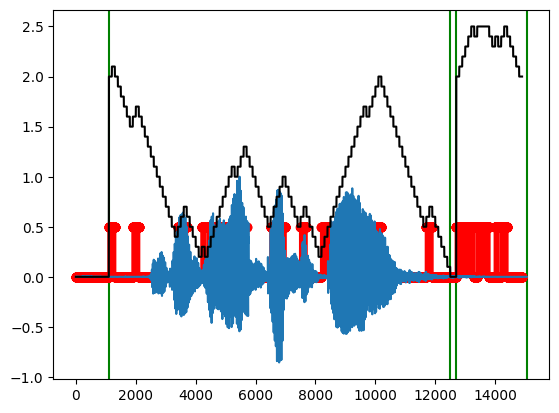

In [309]:
#trying to detect spoken parts with outocorrleation
new_sr = 8000
clip, sr = librosa.load("../data/divide/anja_3.wav")
clip = librosa.resample(clip, orig_sr=sr, target_sr=new_sr)
clip = librosa.to_mono(clip)
clip = normalize(clip)

IS_CURR_VOICED = False

MAX_NUM_FRAMES = 25
START_NUM_FRAMES = 20
MIN_NUM_OF_SAMPLES_IN_SEGMENT = 0.2 * new_sr
MIN_RMS = 0.05

voiced_counter = 0
start_of_segment = -1
end_of_segment = -1
FRAME_SIZE = 100
end_of_checking = (len(clip)//FRAME_SIZE-1) * FRAME_SIZE
out = np.zeros(len(clip)//FRAME_SIZE-1)
curr_voiced_over_time = np.zeros(len(clip)//FRAME_SIZE-1)

for i in range(0, end_of_checking, FRAME_SIZE):
    #for each frame
    bins = np.zeros(FRAME_SIZE)
    bins = get_auto_correlation(clip[i:i+FRAME_SIZE], FRAME_SIZE)
    #plt.stem(bins)
    maximums = np.diff(argrelextrema(bins, np.greater))
    median_maximums = np.median(maximums)
    #if median maximus in some boudaries
    if median_maximums >= 7 and median_maximums <= 20 and np.std(maximums) < 7:
        out[i//FRAME_SIZE] = 1
        voiced_counter = min(voiced_counter + 1,MAX_NUM_FRAMES)
        if  not IS_CURR_VOICED:
            voiced_counter = START_NUM_FRAMES
            IS_CURR_VOICED = True
            start_of_segment = i
    else:
        voiced_counter = max(0, voiced_counter-1)

        if voiced_counter == 0 and IS_CURR_VOICED:
            IS_CURR_VOICED = False
            end_of_segment = i
            #if too short
            if end_of_segment - start_of_segment < MIN_NUM_OF_SAMPLES_IN_SEGMENT:
                continue

            rms = np.sqrt(np.mean(clip[start_of_segment:end_of_segment]**2))
            if rms < MIN_RMS:
                continue

            a = clip[start_of_segment: end_of_segment]
            print(start_of_segment/new_sr, end_of_segment/new_sr)
            plt.axvline(start_of_segment, color='g')
            plt.axvline(end_of_segment, color='g')

    #plt.show() 

    curr_voiced_over_time[i//FRAME_SIZE] = voiced_counter
end_of_segment = len(clip)
if IS_CURR_VOICED and ((end_of_segment - start_of_segment) > MIN_NUM_OF_SAMPLES_IN_SEGMENT):
    plt.axvline(start_of_segment, color='g')
    plt.axvline(end_of_segment, color='g')
    print(end_of_segment - start_of_segment)
#print(start_of_segment/new_sr, end_of_segment/new_sr)
plt.stem(np.repeat(out, FRAME_SIZE)*0.5, 'r')
plt.plot(clip)

plt.plot(np.repeat(curr_voiced_over_time, FRAME_SIZE)*0.1, 'k')
sd.play(a, 8000)
#print(maximums)
#plt.plot(clip)

    TASK 1.2 Normalize between -1 and 1

In [102]:
def normalize(sample):
    sample = sample / np.max(np.abs(sample))
    return sample

TASK 2. FEATURE EXTRACTION

    TASK 2.1 Preemphasis filter

In [28]:
def add_preemphasis_filter(x, coeff=0.95):
    #TODO

    return x

    TASK 2.2 Create MFCC of samles of uniform size (30, 80)

In [25]:
def get_features(y, Fs = 8000):
    y = add_preemphasis_filter(y)
    #20 row mfcc, 20 row delta mfcc, 1 row pitch...
    return y

    TASK 2.3 Other feutures -TODO

Here we see the expmple main function to create train/validate and test set

In [311]:
def make_train_data(directory, training_data_name = "training_data.npy"):
    training_data = []
    eye_in = 0
    NUM_CATEGORIES = len(os.listdir(directory))
    #get al subdirctories in directory
    for category in os.listdir(directory):
        print(category)
        path = os.path.join(directory, category)
        for file in os.listdir(path):
            try:
                #Fs, audio = wavfile.read(os.path.join(path, file))
                clip, sr = librosa.load(os.path.join(path, file))
                clip = librosa.resample(clip, orig_sr=sr, target_sr=8000)
                clip = librosa.to_mono(clip)

                clip = normalize(clip)
                clip = get_voiced_parts(clip,8000)
                if(clip is None):
                    print("{} not good".format(os.path.join(path, file)))
                    continue
                features = get_features(clip)

                training_data.append([clip, np.eye(NUM_CATEGORIES)[eye_in]])
            except Exception as e:
                print(e)
                pass
        eye_in += 1
        #return training_data
    np.random.shuffle(training_data)
    return training_data
        
training_data = make_train_data("../data")

np.save("training_data.npy", training_data)
print(len(training_data))

divide


C:\Users\38631\AppData\Local\Temp\ipykernel_14660\1287568242.py:2: RuntimeWarning: divide by zero encountered in divide
  sample = sample / np.max(np.abs(sample))
C:\Users\38631\AppData\Local\Temp\ipykernel_14660\1287568242.py:2: RuntimeWarning: invalid value encountered in divide
  sample = sample / np.max(np.abs(sample))


../data\divide\lars_1.wav not good
../data\divide\lars_2.wav not good
../data\divide\lars_3.wav not good
../data\divide\lars_4.wav not good
../data\divide\lars_5.wav not good


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (25, 2) + inhomogeneous part.

[array([0.16205204, 0.24612331, 0.3119922 , ..., 0.00918243, 0.0117647 ,
       0.00805661], dtype=float32), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])]


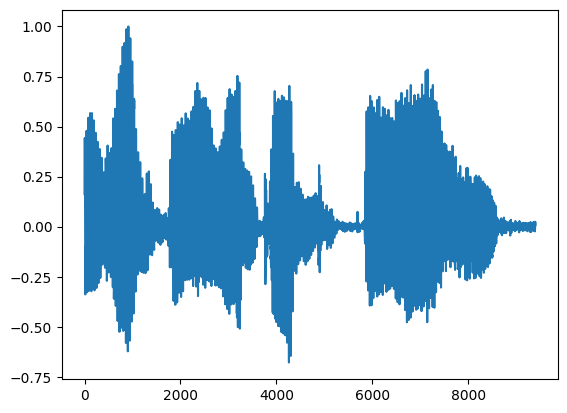

In [313]:
INDEX = 5
print(training_data[INDEX])
plt.plot(training_data[INDEX][0])
sd.play(training_data[INDEX][0],8000)
sd.wait()

In [2]:
# Read file names
path = os.path
files = {}

data_dir = os.listdir(
    path.join(os.getcwd(), '..', 'data')
)

for dir in data_dir:
    audio_files = os.listdir(
        path.join(os.getcwd(), '..', 'data', dir)
    )

    files[dir] = []
    files[dir].append(audio_files)

In [3]:
# Read audio signals
f = open('data.csv', 'w')
writer = csv.writer(f)

writer.writerow(['label', 'feature 1', 'feature 2', 'feature 3'])

for dir in files:
    for file in files[dir][0]:
        audio, sr = librosa.core.load(
            path.join(os.getcwd(), '..', 'data', dir, file)
        )

        writer.writerow([dir, audio[0], audio[1], audio[2]])

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
